# Reconstructing non-aligned frequencies

As we saw in Clare3, when the template/signal frequency does not lie on a bin boundary it means that
- a) the wave is not periodic within the signal window and thus
- b) it will take a sum of periodic sines to produce that frequency so that
- c) the Short Fourier Transform will show energy in more than one bin.

Thus, we need to combine the information from several Fourier bins to regenerate the original signal. Let's look at how this needs to work.

If the original signal, with amplitude $A$, is on one of the bin edges then the SFT is zero except at one bin where the value is $NA$, where $N$ is the number of points in the input data.

If the original signal is NOT on a bin edge then the SFT is peaked on the nearest bin edge but has non-zero components in all bins. We then have to appeal to Parseval's theorem to understand how to combine those components to reconstruct the amplitude of the original signal. Parseval's theorem for the Discrete Fourier Transform reads (see Wikipedia)
$$\sum_{n=0}^{N-1}|x_{n}|^2=\dfrac{1}{N}\sum_{k=0}^{N-1}|F_{k}|^2$$
where the $F_{k}$ are the Fourier components of the discrete signal $x_{n}$.

This tells us that we want to add together the squares of the magnitudes of the fourier coefficients NOT rotate and sum them as I have been doing. The easiest way to get the sum of the squares is to take the complex dot product of the SFT with itself, that is to multiply the SFT by its complex conjugate.

As Keith's handwritten note to Clare showed, when the signal is contaminated by noise it becomes advantageous to take the dot product not with the SFT of the noisy signal but with the SFT of the noise-free template. It is this process that I want to examine. However, I am going to start with a noise-free signal to verify that we have the details of the process correct.

## The Noise-Free case

We start, as always, by loading a few tools.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Then we construct a signal. For this purpose we do not need to worry about starting with a very long signal and chopping it into frames as this process takes place purely within a single frame. I am choosing a signal that lies 1/4 of the way through a frame.

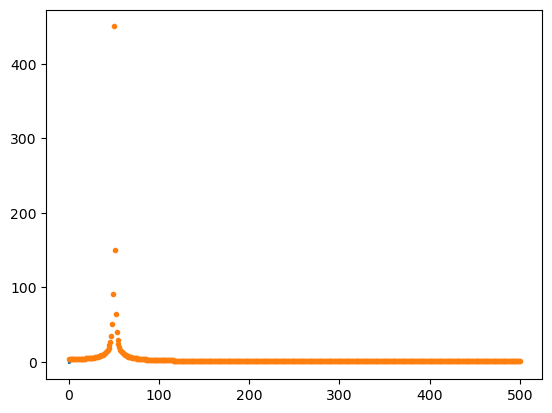

In [6]:
rate = 1_000
duration = 1.0
nSample = int(rate * duration)
time = np.linspace(0.0, duration, num=nSample, endpoint=False)
freq0 = 50.25
w0 = 2 * np.pi * freq0
sig = np.cos(w0 * time)
plt.plot(time, sig)
SFT = np.fft.rfft(sig)
nFreq = int(nSample/2)+1
freq = np.linspace(0, 1/(time[2]-time[0]), num=nFreq)
plt.plot(freq, np.absolute(SFT), '.')

There we see the central peak has fallen from its ideal value of 500 to about 450 but there are side peaks with values in the 100-200 value range so we can't get the right value by adding these peaks. Instead we dot the spectrum with its complex conjugate.

In [9]:
dot = np.sum(SFT * np.conjugate(SFT))
print(np.sqrt(dot.real))

500.25665060586704


Well, look at that! I don't know why it is not closer than that but a 0.04% discrepancy is not bad.

In [13]:
print(np.sqrt(np.vdot(SFT, SFT).real))

500.25665060586704


## Once more with noise

Repeating that calculation with our canonical noise.

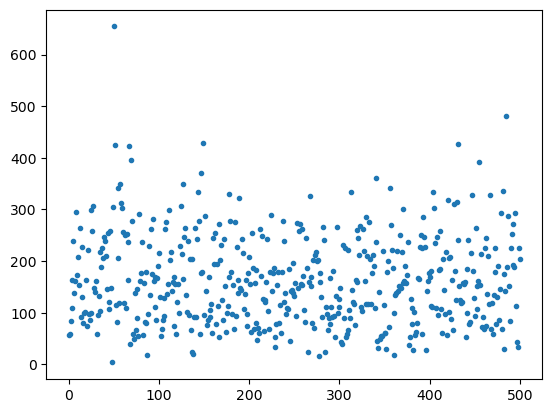

In [16]:
rng = np.random.default_rng()
noise = rng.uniform(low=-10.0, high=10.0, size=nSample)
nSig = sig + noise
nSFT = np.fft.rfft(nSig)
plt.plot(freq, np.absolute(nSFT), '.')

So we can see the signal emerging out of the noise. If we do our dot product using the DATA we get a pretty rubbish result

In [17]:
print(np.sqrt(np.vdot(nSFT, nSFT).real))

4152.002949355111


but if we do the dot product with the noise-free SFT we get

In [18]:
print(np.sqrt(np.vdot(SFT, nSFT).real))

614.061777832724


MUCH closer. And if we do the latter technique with pure noise

In [19]:
pnSFT = np.fft.rfft(noise)
print(np.sqrt(np.vdot(SFT, pnSFT).real))

356.11114910893383


we see that we have gone from 1:10 SNR to a 2:1 SNR, which is pretty much what our eye would have told us for the noisy data.

## Template imperfections

What happens if the frequency of our template does not match the frequency of our actual signal? Let's try a range of signal frequencies from 50 Hz to 51 Hz and see how our recovered signal varies. I think that we can try this without noise.

In [21]:
freq1 = 50.1
w1 = 2 * np.pi * freq1
sig1 = np.cos(w1 * time)
SFT1 = np.fft.rfft(sig1)
print(np.sqrt(np.vdot(SFT, SFT1).real))

463.85562293982497


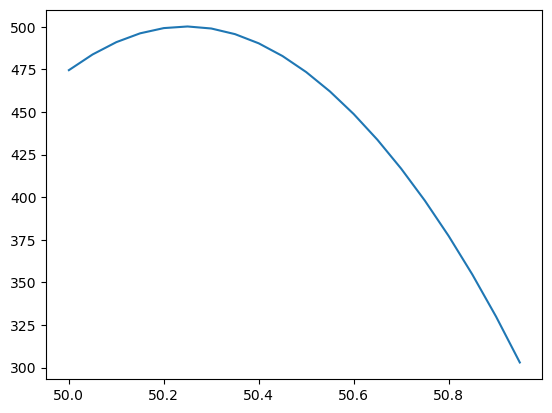

In [27]:
freqi = np.zeros(20)
compi = np.zeros(20)
for i in range(20):
    freqi[i] = 50 + i/20
    wi = 2 * np.pi * freqi[i]
    sigi = np.cos(wi * time)
    SFTi = np.fft.rfft(sigi)
    doti = np.vdot(SFT, SFTi)
    # print(freqi[i], doti)
    compi[i] = np.sqrt(np.absolute(doti))
plt.plot(freqi, compi)

Well, that is rather nice. You lose, but not horribly.